#  Modèle Hybride CatBoost



In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ajout du dossier src au path
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import DATA_DIR, ARTIFACTS_DIR
from src.models.catboost.dataset import CatboostDatasetBuilder
from src.models.catboost.trainer import CatboostTrainer
from src.models.catboost.predictor import HybridPredictor
from src.pipelines.baseline_pipeline import BaselineArtifact
from src.evaluation.evaluate_V2 import evaluate_masking

## 1. Chargement et Nettoyage

In [2]:
train_path = DATA_DIR / "Train.csv"
test_path = DATA_DIR / "Test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Définition des colonnes (même logique que Baseline)
PROFILE_COLS = [
    "ID","join_date","sex","marital_status","birth_year",
    "branch_code","occupation_code","occupation_category_code"
]
PRODUCT_COLS = [c for c in df_train.columns if c not in PROFILE_COLS]

print(f"Produits ({len(PRODUCT_COLS)}): {PRODUCT_COLS}")

Produits (21): ['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']


In [3]:
def normalize_cat(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.casefold()

def apply_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Normalisation des catégorielles
    for c in ["sex", "marital_status", "branch_code", "occupation_code", "occupation_category_code"]:
        out[c] = normalize_cat(out[c])
    
    # Join Year
    jy = pd.to_numeric(out["join_date"].astype(str).str.split("/").str[-1], errors="coerce")
    out["join_year"] = jy.fillna(2017) # Fillna moyenne/mode rapide
    
    # Age
    out["age"] = (out["join_year"] - out["birth_year"]).clip(18, 90).fillna(38)
    
    return out

df_train_clean = apply_cleaning(df_train)
df_test_clean = apply_cleaning(df_test)

## 2. Préparation du Dataset Supervisé

Nous divisons le train en deux :
- **Train Split** (80%) : Pour entraîner CatBoost avec Smart Masking.
- **Val Split** (20%) : Pour évaluer la performance Hybride (produit masqué).

In [4]:
from sklearn.model_selection import train_test_split

# On garde uniquement les clients avec au moins 2 produits pour le 'val' (pour pouvoir en cacher 1)
# Mais pour le train, on peut utiliser tout le monde (même taille 1 pour apprendre le profil? Non, besoin de target)
# Le dataset builder filtre automatiquent min_basket=2

ids_unique = df_train_clean["ID"].unique()
train_ids, val_ids = train_test_split(ids_unique, test_size=0.2, random_state=42)

df_local_train = df_train_clean[df_train_clean["ID"].isin(train_ids)].copy()
df_local_val = df_train_clean[df_train_clean["ID"].isin(val_ids)].copy()

print(f"Train local: {df_local_train.shape}, Val local: {df_local_val.shape}")

Train local: (23305, 31), Val local: (5827, 31)


In [5]:
# Configuration du Builder
CAT_FEATURES = ["sex", "marital_status", "branch_code", "occupation_code", "occupation_category_code"]

builder = CatboostDatasetBuilder(
    product_cols=PRODUCT_COLS,
    cat_cols=CAT_FEATURES,
    random_state=42
)

print("Construction du dataset train avec Smart Masking...")
X_train, y_train = builder.build_dataset(df_local_train, strategy='smart', min_basket=2)

print(f"X_train shape: {X_train.shape}")
print(X_train.head(3))

Construction du dataset train avec Smart Masking...
X_train shape: (23305, 29)
  sex marital_status  birth_year branch_code occupation_code  \
0   f              m        1987        1x1h            2a7i   
1   f              m        1981        uaod            2a7i   
2   m              u        1991        748l            qzyx   

  occupation_category_code  join_year   age  P5DA  RIBP  ...  AHXO  BSTQ  \
0                     t4ms     2019.0  32.0     0     0  ...     0     0   
1                     t4ms     2019.0  38.0     0     0  ...     0     0   
2                     90qi     2013.0  22.0     0     0  ...     0     0   

   FM3X  K6QO  QBOL  JWFN  JZ9D  J9JW  GHYX  ECY3  
0     0     0     0     0     0     0     0     0  
1     0     1     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     0  

[3 rows x 29 columns]


## 3. Entraînement CatBoost

In [6]:

trainer = CatboostTrainer(
    cat_features=CAT_FEATURES,
    iterations=500,
    learning_rate=0.1,
    depth=6
)

trainer.fit(X_train, y_train)

0:	learn: 0.7385540	total: 3.26s	remaining: 27m 7s
100:	learn: 0.8341987	total: 4m 57s	remaining: 19m 36s
200:	learn: 0.8490882	total: 10m 32s	remaining: 15m 41s
300:	learn: 0.8586569	total: 16m 13s	remaining: 10m 43s
400:	learn: 0.8647930	total: 21m 16s	remaining: 5m 15s
499:	learn: 0.8709719	total: 26m 38s	remaining: 0us


In [9]:
# Sauvegarde du modèle
save_path = ARTIFACTS_DIR / "catboost_model_v1.cbm"
trainer.save(save_path)
print(f"Modèle sauvegardé dans : {save_path}")

Modèle sauvegardé dans : C:\Users\gouab\Desktop\Projet_perso\insurance_recommender\Insurance_product_recommender\artifacts\catboost_model_v1.cbm


In [10]:
# Pour recharger le modèle sans ré-entraîner
save_path = ARTIFACTS_DIR / "catboost_model_v1.cbm"

if save_path.exists():
    print("Chargement du modèle existant...")
    # On réinitialise un trainer vide
    trainer = CatboostTrainer(
        cat_features=CAT_FEATURES,
        iterations=500,
        learning_rate=0.1,
        depth=6
    )
    trainer.load(save_path)
else:
    print("Entraînement du modèle...")
    trainer = CatboostTrainer(
        cat_features=CAT_FEATURES,
        iterations=500,
        learning_rate=0.1,
        depth=6
    )
    trainer.fit(X_train, y_train)
    trainer.save(save_path)

Chargement du modèle existant...


## 4. Évaluation Hybride (Validation)

On charge la baseline pour l'hybridation.

In [11]:
# Chargement Baseline Artifact
baseline_art = BaselineArtifact.load(ARTIFACTS_DIR / "baseline_v0")

# Création du Prédicteur Hybride
hybrid_model = HybridPredictor(trainer, baseline_art)

In [13]:
# Préparation des données de validation pour evaluate_masking
# evaluate_masking attend X_full (produits) et utilise score_fn(x, idx)
# Pour que score_fn accède au contexte, on a besoin d'accéder à df_local_val via idx

# On doit s'assurer que les indices correspondent.
df_local_val = df_local_val.reset_index(drop=True)
X_val_full = df_local_val[PRODUCT_COLS].values

# Fonction de scoring wrapper
# Fonction de scoring wrapper CORRIGÉE
def hybrid_scorer(x_row_obs, idx_original):
    # 1. Reconstruire le contexte (profil)
    context_row = df_local_val.iloc[[idx_original]].copy()
    
    # 2. Mettre à jour les produits observés dans le contexte
    context_row[PRODUCT_COLS] = x_row_obs # Broadcast
    
    # --- FIX CRITIQUE ---
    # On ne garde QUE les colonnes utilisées lors de l'entraînement
    # (CatBoost est perdu s'il voit 'ID' ou 'join_date' en plus, ça décale tout)
    train_cols = X_train.columns
    context_row = context_row[train_cols]
    # --------------------
    
    # 3. Prédiction
    probas = hybrid_model.predict_proba(context_row, alpha=0.3)
    return probas[0]
# Évaluation
print("Évaluation sur le set de validation...")
info, metrics = evaluate_masking(
    X_full=X_val_full, 
    score_fn=hybrid_scorer, 
    hide_k=1, 
    min_observed=1
)

print("\n--- Résultats Hybride (Alpha=0.3) ---")
print(metrics)

Évaluation sur le set de validation...

--- Résultats Hybride (Alpha=0.3) ---
Hit@1        0.862022
Recall@1     0.862022
Hit@3        0.959499
Recall@3     0.959499
Hit@5        0.979063
Recall@5     0.979063
Hit@10       0.996739
Recall@10    0.996739
dtype: float64


## 5. Analyse de l'Importance des Features

                 Feature Id  Importances
0                      RVSZ    27.197981
1                      K6QO    21.406972
2               branch_code    11.188313
3                 join_year     9.217899
4           occupation_code     8.604418
5            marital_status     5.385934
6  occupation_category_code     3.330932
7                      QBOL     2.427463
8                birth_year     2.094240
9                      J9JW     2.012033


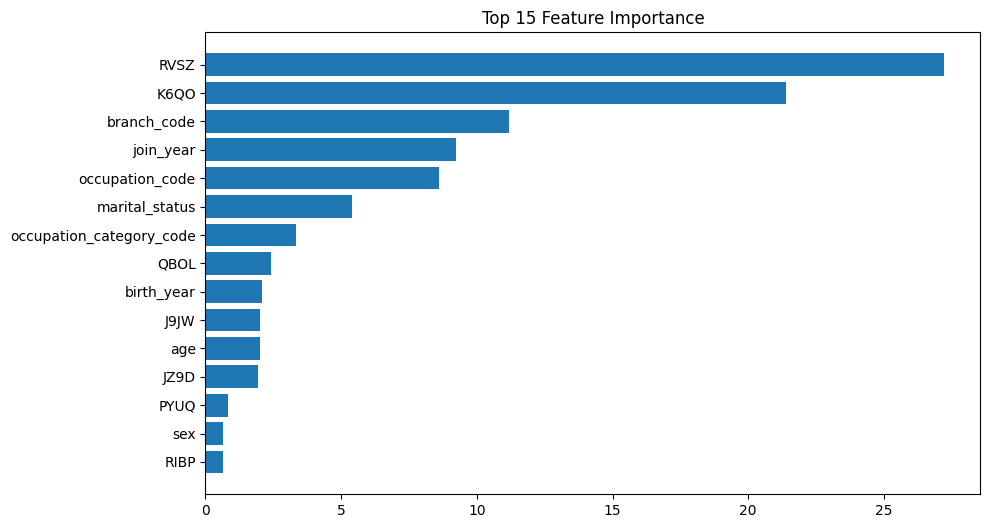

In [14]:
fi = trainer.model.get_feature_importance(prettified=True)
print(fi.head(10))

plt.figure(figsize=(10, 6))
pl = fi.head(15)
plt.barh(pl["Feature Id"], pl["Importances"])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importance")
plt.show()

## 6. Comparaison Finale : Baseline vs Hybride

C'est le moment de vérité. On compare la Baseline pure (V0) contre notre nouveau modèle Hybride (V1) sur le même set de validation.
On s'attend à ce que l'Hybride soit meilleur, surtout sur le Hit@1.

Évaluation de la Baseline Pure...

=== Comparaison des Performances ===
           Baseline (V0)  Hybride (V1)    Gain
Hit@1             0.8226        0.8620  0.0395
Recall@1          0.8226        0.8620  0.0395
Hit@3             0.9211        0.9595  0.0384
Recall@3          0.9211        0.9595  0.0384
Hit@5             0.9628        0.9791  0.0163
Recall@5          0.9628        0.9791  0.0163
Hit@10            0.9861        0.9967  0.0106
Recall@10         0.9861        0.9967  0.0106


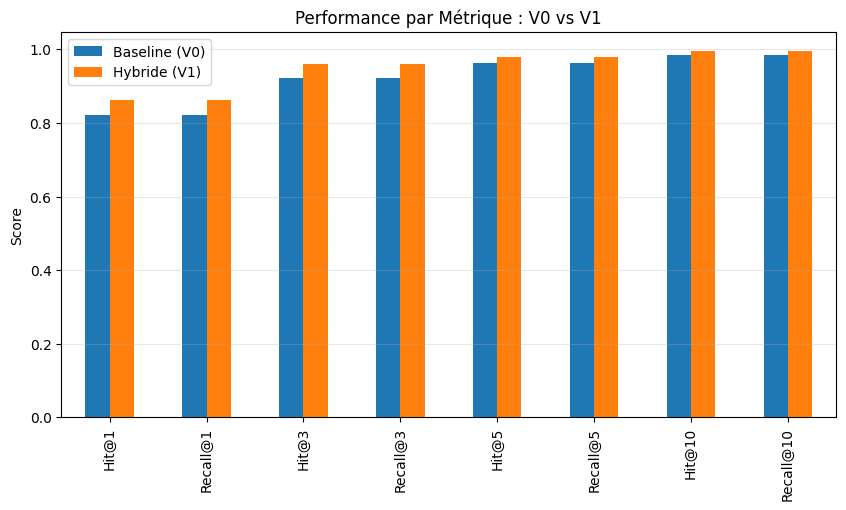

In [17]:
# 1. On recrée le modèle Baseline à partir de l'Artifact chargé
from src.baselines.conditional import ConditionalBaseline
baseline_model = ConditionalBaseline.from_stats(
    product_cols=baseline_art.product_cols, 
    cond=baseline_art.cond, 
    support_A=baseline_art.support_A
)

print("Évaluation de la Baseline Pure...")
def baseline_scorer(x_row_obs, idx_original):
    # Maintenant on utilise baseline_model qui a la méthode score_one
    return baseline_model.score_one(x_row_obs)

_, metrics_bl = evaluate_masking(
    X_full=X_val_full, 
    score_fn=baseline_scorer, 
    hide_k=1, 
    min_observed=1
)

# 2. Comparaison
comp_df = pd.DataFrame({
    "Baseline (V0)": metrics_bl,
    "Hybride (V1)": metrics
})
comp_df["Gain"] = comp_df["Hybride (V1)"] - comp_df["Baseline (V0)"]

print("\n=== Comparaison des Performances ===")
print(comp_df.round(4))

# Petit plot
comp_df[[ "Baseline (V0)", "Hybride (V1)"]].plot(kind='bar', figsize=(10, 5))
plt.title("Performance par Métrique : V0 vs V1")
plt.ylabel("Score")
plt.grid(axis='y', alpha=0.3)
plt.show()